# Machine Learning Dataset Analysis

The goal is to be able to predict winners of Major League Baseball games based on betting odds and lines, as well as other factors like ballpark for example.

## Step 1. Import Dependencies

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## Step 2. Load the Data and Execute Feature Engineering

In [4]:
# Load the cleaned dataset
df = pd.read_csv('Data/Cleaned_OddsData.csv')

# Create the target variable (1 if team won, 0 if team lost)
df['winner'] = (df['runs'] > df['oppRuns']).astype(int)

# Convert odds to implied probability
def moneyline_to_prob(odds):
    return abs(odds) / (abs(odds) + 100) if odds > 0 else 100 / (100-odds)

df['implied_prob'] = df['moneyLine'].apply(moneyline_to_prob)
df['opp_implied_prob'] = df['oppMoneyLine'].apply(moneyline_to_prob)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['team', 'opponent', 'parkName'], drop_first=True)

# Select features
features = [
    'implied_prob', 'opp_implied_prob','projectedRuns', 
    'total', 'overOdds', 'underOdds',
] + [col for col in df.columns if col.startswith('team_') or col.startswith('opponent_') or col.startswith('parkName_')]

X = df[features]
y = df['winner']

## Step 3. Train/Test Split

In [5]:
# Sort by first date
df = df.sort_values(by='date')

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

## Step 4. Train a Model

In [8]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log loss:", log_loss(y_test, y_proba))

Accuracy: 0.5540351857023178
Log loss: 0.7015068480299393


In [18]:
# Train the model
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train, y_train)

# Predict
y_pred2 = model2.predict(X_test)
y_proba2 = model2.predict_proba(X_test)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Log loss:", log_loss(y_test, y_proba2))

Accuracy: 0.5872661267802289
Log loss: 0.6708636261274586


## Step 5. ROI Simulation

In [11]:
# Bet on model picks where win probability > 0.5
bet_mask = y_proba > 0.5
bets = df.iloc[y_test.index][bet_mask]

# Calculate ROI if betting 1 unit on each pick
bets['return'] = bets.apply(
    lambda row: (row['moneyLine'] / 100 if row['moneyLine'] > 0 else 100 / abs(row['moneyLine'])) if row['winner'] == 1 else -1,
    axis=1
)

roi = bets['return'].mean()
print("Average ROI per bet:", roi)

Average ROI per bet: -0.02265161935996266


C:\Users\trent\AppData\Local\Temp\ipykernel_41916\3819293575.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  roi_by_bin = bets.groupby('odds_bin')['return'].mean()


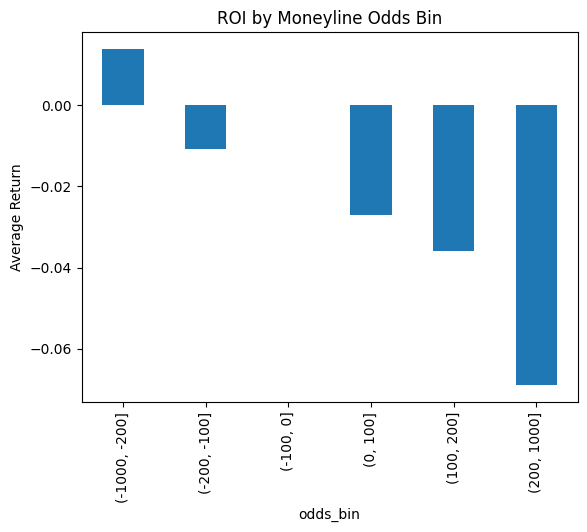

In [13]:
# ROI by odds bins
bets['odds_bin'] = pd.cut(bets['moneyLine'], bins=[-1000, -200, -100, 0, 100, 200, 1000])
roi_by_bin = bets.groupby('odds_bin')['return'].mean()

roi_by_bin.plot(kind='bar')
plt.ylabel('Average Return')
plt.title('ROI by Moneyline Odds Bin')
plt.show()

## Step 6. Model Results

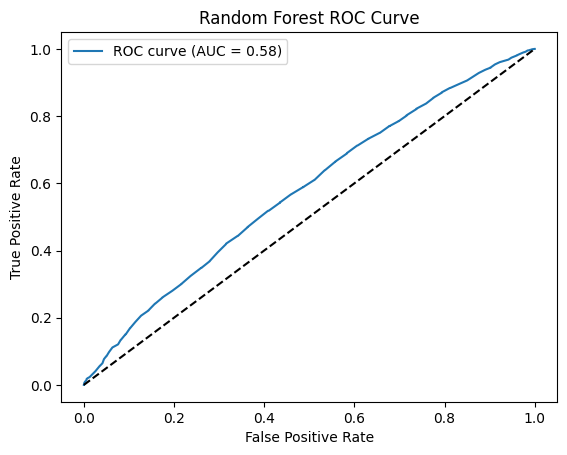

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()


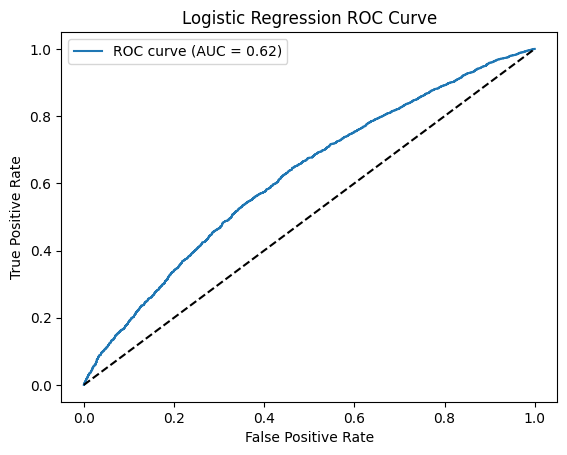

In [21]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba2)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()